In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import balanced_accuracy_score, classification_report
from skopt import BayesSearchCV
import json
import pickle
import time
import wandb
import re

In [2]:
config_data = json.load(open('../config.json'))
HF_TOKEN = config_data['HF_TOKEN']
WANDB_TOKEN = config_data['WANDB_TOKEN']

wandb.login(key=WANDB_TOKEN)

run = wandb.init(
    project='wz_experimental',
    config={"model_name": "XGBoost"}
)

wandb: Currently logged in as: kawishbit (kawishbit-org). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\kawis\_netrc


In [3]:
id_to_label_mapping = {0: 'A1', 1: 'A2', 2: 'B1', 3: 'B2', 4: 'C1', 5: 'C2'}
label_to_id_mapping = {'A1': 0, 'A2': 1, 'B1': 2, 'B2': 3, 'C1': 4, 'C2': 5}
cefr_levels = ["A1", "A2", "B1", "B2", "C1", "C2"]

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [4]:
config = wandb.config

config.maxlen = 1000
config.vocab_size = 30000
config.embedding_dims = 200
config.epochs = 7
config.hidden_dims = 200
config.batch_size = 32

In [5]:
train_set = pd.read_csv('../datasets/quotes/quotes_train.csv', encoding="latin1")
test_set = pd.read_csv('../datasets/quotes/quotes_test.csv', encoding="latin1")

train_set.head()

,text,label,level
0,always be yourself express yourself have fai...,1,A2
1,i passionately believe home cooking has vast b...,1,A2
2,it is the attention we give to bad situations ...,0,A1
3,looking back i wonder if mom saw it in my eye...,1,A2
4,since beginners can only remain in contact wit...,2,B1


In [6]:
data = pd.concat([train_set,test_set], axis=0)

data.reset_index(inplace=True)

In [7]:
cleanedData = []

lemma = WordNetLemmatizer()
swords = stopwords.words("english")
for text in data["text"]:
    text = nltk.word_tokenize(text.lower())
    text = [lemma.lemmatize(word) for word in text]

    # Removing stopwords
    text = [word for word in text if word not in swords]

    # Joining
    text = " ".join(text)

    cleanedData.append(text)

In [8]:
vectorizer = TfidfVectorizer(max_features=config.vocab_size)
BOW = vectorizer.fit_transform(cleanedData)

In [9]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(BOW,np.asarray(data["label"]))

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(15684, 24621)
(5229, 24621)
(15684,)
(5229,)


In [10]:
from xgboost import XGBClassifier
from skopt.space import Real, Integer
start_time = time.time()

search_space = {
    'max_depth': Integer(3, 10),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0)
}

xgb = XGBClassifier(n_estimators=100, objective='binary:logistic', random_state=42)
bayes_search = BayesSearchCV(estimator=xgb, search_spaces=search_space, n_iter=25, cv=3, n_jobs=-1, verbose=2)
bayes_search.fit(x_train, y_train)

model = bayes_search.best_estimator_

end_time = time.time()
process_time = round(end_time-start_time,2)
print("Fitting XGBoost took {} seconds".format(process_time))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

In [11]:
from sklearn.metrics import accuracy_score,confusion_matrix
predictions = model.predict(x_test)
print("Accuracy of model is {}%".format(accuracy_score(y_test,predictions) * 100))

Accuracy of model is 52.70606234461657%


In [12]:
print(predictions)
print(y_test)

[0 0 0 ... 3 0 2]
[0 1 0 ... 3 0 4]


Accuracy: 0.527
Accuracy for label A1: 0.798
Accuracy for label A2: 0.481
Accuracy for label B1: 0.197
Accuracy for label B2: 0.556
Accuracy for label C1: 0.102
Accuracy for label C2: 0.000

Classification Report:
              precision    recall  f1-score   support

          A1       0.64      0.80      0.71      1674
          A2       0.47      0.48      0.47      1454
          B1       0.36      0.20      0.26       948
          B2       0.48      0.56      0.52       917
          C1       0.40      0.10      0.16       225
          C2       0.00      0.00      0.00        11

    accuracy                           0.53      5229
   macro avg       0.39      0.36      0.35      5229
weighted avg       0.50      0.53      0.50      5229


Confusion Matrix:
[[1336  287   17   33    1    0]
 [ 509  700  130  112    3    0]
 [ 164  342  187  247    8    0]
 [  69  157  159  510   22    0]
 [  18   15   21  148   23    0]
 [   0    0    0   11    0    0]]


C:\Users\kawis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kawis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kawis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kawis\anaconda3\Lib\site-packag

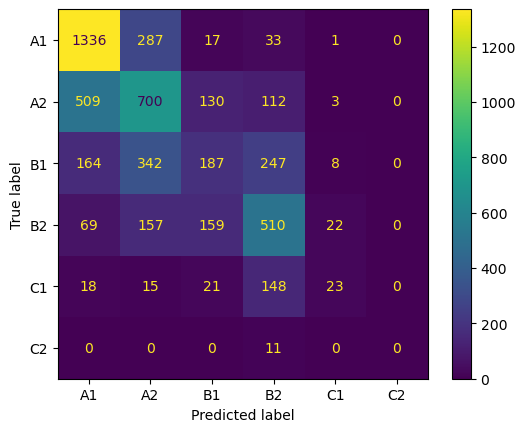

In [13]:
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = predictions

y_true = y_test

def map_func(x):
    return x if str(x).isnumeric() else label_to_id_mapping.get(x, -1)

y_true_mapped = np.vectorize(map_func)(y_true)
y_pred_mapped = np.vectorize(map_func)(y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_true=y_true_mapped, y_pred=y_pred_mapped)
print(f'Accuracy: {accuracy:.3f}')

# Generate accuracy report
unique_labels = set(y_true_mapped)  # Get unique labels

for label in unique_labels:
    label_indices = [i for i in range(len(y_true_mapped)) if y_true_mapped[i] == label]
    label_y_true = [y_true_mapped[i] for i in label_indices]
    label_y_pred = [y_pred_mapped[i] for i in label_indices]
    label_accuracy = accuracy_score(label_y_true, label_y_pred)
    print(f'Accuracy for label {cefr_levels[label]}: {label_accuracy:.3f}')

class_report = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=cefr_levels, labels=list(range(len(cefr_levels))))
class_report_dict = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=cefr_levels, labels=list(range(len(cefr_levels))), output_dict=True)
print('\nClassification Report:')
print(class_report)
table_data = []

for key, value in class_report_dict.items():
    if isinstance(value, dict):
        table_data.append([
            key,
            value.get("precision", 0),
            value.get("recall", 0),
            value.get("f1-score", 0),
            value.get("support", 0)
        ])
    else:
        # For accuracy, add precision and recall as 0
        table_data.append([
            key,
            0,
            0,
            value,
            class_report_dict["weighted avg"]["support"]
        ])

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true=y_true_mapped, y_pred=y_pred_mapped, labels=list(range(len(cefr_levels))))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=cefr_levels)
disp.plot()


print('\nConfusion Matrix:')
print(conf_matrix)

wandb.log({
    "Class Proportions": wandb.sklearn.plot_class_proportions(train_set['level'], test_set['level'], cefr_levels),
    "Confusion Matrix": plt,
    "Classification Report": wandb.Table(data=table_data, columns=['Class/Metric', 'Precision', 'Recall', 'F1-score', 'Support'])
})

In [14]:
wandb.finish()